In [1]:
!git clone https://github.com/balajisrinivas/Face-Mask-Detection.git

Cloning into 'Face-Mask-Detection'...
remote: Enumerating objects: 3764, done.
remote: Total 3764 (delta 0), reused 0 (delta 0), pack-reused 3764
Receiving objects: 100% (3764/3764), 143.05 MiB | 43.88 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D,Dense,Dropout,Flatten,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import os
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths

In [4]:
INIT_LR=1e-4
EPOCHS = 20
BS = 32

In [6]:
DIRECTORY = "/content/Face-Mask-Detection/dataset"
CATEGORIES = ["with_mask","without_mask"]

In [8]:
data=[]
labels=[]

for category in CATEGORIES:
  path =os.path.join(DIRECTORY,category)
  for img in os.listdir(path):
    img_path = os.path.join(path,img)
    image = load_img(img_path,target_size=(224,224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(category)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [31]:
lb = LabelBinarizer()
labels=lb.fit_transform(labels)
labels

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [32]:
labels = to_categorical(labels)
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [33]:
data=np.array(data)
labels=np.array(labels)
data.shape,labels.shape

((3833, 224, 224, 3), (3833, 2))

In [34]:
X_train, X_test, y_train, y_test = train_test_split(data,labels, test_size=0.2,stratify=labels, random_state=42)

In [35]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [36]:
base_model = MobileNetV2(include_top=False,input_tensor=Input(shape=(224,224,3)))

In [42]:
headModel= base_model.output
headModel= AveragePooling2D(pool_size=(7,7))(headModel)
headModel= Flatten()(headModel)
headModel= Dense(128,activation='relu')(headModel)
headModel= Dropout(0.5)(headModel)
headModel= Dense(2,'softmax')(headModel)
model = Model(inputs=base_model.input,outputs=headModel)
for layer in base_model.layers:
  layer.trainable= False

In [43]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [44]:
y_test.shape,y_train.shape

((767, 2), (3066, 2))

In [45]:
X_train.shape,X_test.shape

((3066, 224, 224, 3), (767, 224, 224, 3))

In [46]:
opt =Adam(learning_rate=INIT_LR)
model.compile(opt,loss='binary_crossentropy',metrics=['accuracy'])

In [47]:
H = model.fit(
    aug.flow(X_train,y_train,batch_size=BS),
    steps_per_epoch=len(X_train)//BS,
    validation_data=(X_test,y_test),
    validation_steps=len(X_test)//BS,
    epochs=EPOCHS
)

Epoch 1/20
95/95 [==============================] - 34s 332ms/step - loss: 0.5951 - accuracy: 0.7290 - val_loss: 0.1643 - val_accuracy: 0.9778
Epoch 2/20
95/95 [==============================] - 30s 318ms/step - loss: 0.1738 - accuracy: 0.9569 - val_loss: 0.0917 - val_accuracy: 0.9804
Epoch 3/20
95/95 [==============================] - 30s 316ms/step - loss: 0.1060 - accuracy: 0.9708 - val_loss: 0.0682 - val_accuracy: 0.9844
Epoch 4/20
95/95 [==============================] - 30s 317ms/step - loss: 0.0793 - accuracy: 0.9817 - val_loss: 0.0567 - val_accuracy: 0.9831
Epoch 5/20
95/95 [==============================] - 30s 316ms/step - loss: 0.0642 - accuracy: 0.9827 - val_loss: 0.0537 - val_accuracy: 0.9831
Epoch 6/20
95/95 [==============================] - 30s 315ms/step - loss: 0.0560 - accuracy: 0.9817 - val_loss: 0.0491 - val_accuracy: 0.9857
Epoch 7/20
95/95 [==============================] - 30s 318ms/step - loss: 0.0533 - accuracy: 0.9826 - val_loss: 0.0517 - val_accuracy: 0.9804

In [48]:
model.save('face_mask.h5')

In [56]:
y_pred = model.predict(X_test,batch_size=BS)
y_pred = np.argmax(y_pred,axis=1)
# print(classification_report(y_test.argmax(axis=1),y_pred,target_names=lb.classes_))
y_test_report = y_test.argmax(axis=1)

In [58]:
print(classification_report(y_test_report,y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       383
           1       1.00      0.98      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



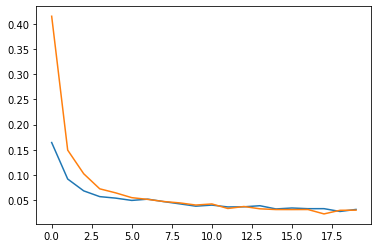

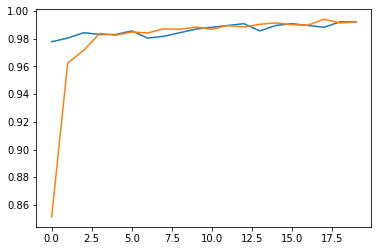

In [61]:
plt.plot(H.history['val_loss'])
plt.plot(H.history['loss'])
plt.show()
plt.plot(H.history['val_accuracy'])
plt.plot(H.history['accuracy'])
plt.show()

In [1]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

#load model
model = load_model('face_mask.h5')


face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')


cap=cv2.VideoCapture(0)

while True:
    ret,test_img=cap.read()# captures frame and returns boolean value and captured image
    if not ret:
        continue
    gray_img= cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)


    for (x,y,w,h) in faces_detected:
        cv2.rectangle(test_img,(x,y),(x+w,y+h),(255,0,0),thickness=7)
        roi_gray=gray_img[y:y+w,x:x+h]#cropping region of interest i.e. face area from  image
        roi_gray=cv2.resize(roi_gray,(224,224))
        img_pixels = image.img_to_array(roi_gray)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        img_pixels /= 255.

        predictions = model.predict(img_pixels)

        #find max indexed array
        max_index = np.argmax(predictions[0])

        mask = ('Mask',"NO Mask")
        predicted_mask = mask[max_index]

        cv2.putText(test_img, predicted_mask, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

    resized_img = cv2.resize(test_img, (1000, 700))
    cv2.imshow('Facial emotion analysis ',resized_img)



    if cv2.waitKey(10) == ord('q'):#wait until 'q' key is pressed
        break

cap.release()
cv2.destroyAllWindows

<function destroyAllWindows>